# Explanatory Analysis

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
from scipy import stats
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv("https://gist.githubusercontent.com/cloudwalk-tests/76993838e65d7e0f988f40f1b1909c97/raw/295d9f7cb8fdf08f3cb3bdf1696ab245d5b5c1c9/transactional-sample.csv") 

df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['has_cbk'] = df['has_cbk'].map({True:1, False:0}) #Label encoding  
df['ts'] = ((df['transaction_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s"))

## 2. Chargeback Distribution

In [3]:
print(df['has_cbk'].value_counts())
print(df['has_cbk'].value_counts(normalize=True))

has_cbk
0    2808
1     391
Name: count, dtype: int64
has_cbk
0    0.877774
1    0.122226
Name: proportion, dtype: float64


Our first problem, as expected is a highly imbalanced dataset.

# 3. Amount and Time Distributions

In [13]:
#Creating log variables 
df['log_amount'] = np.log(df['transaction_amount']) 
df['log_ts'] = np.log(df['ts'])

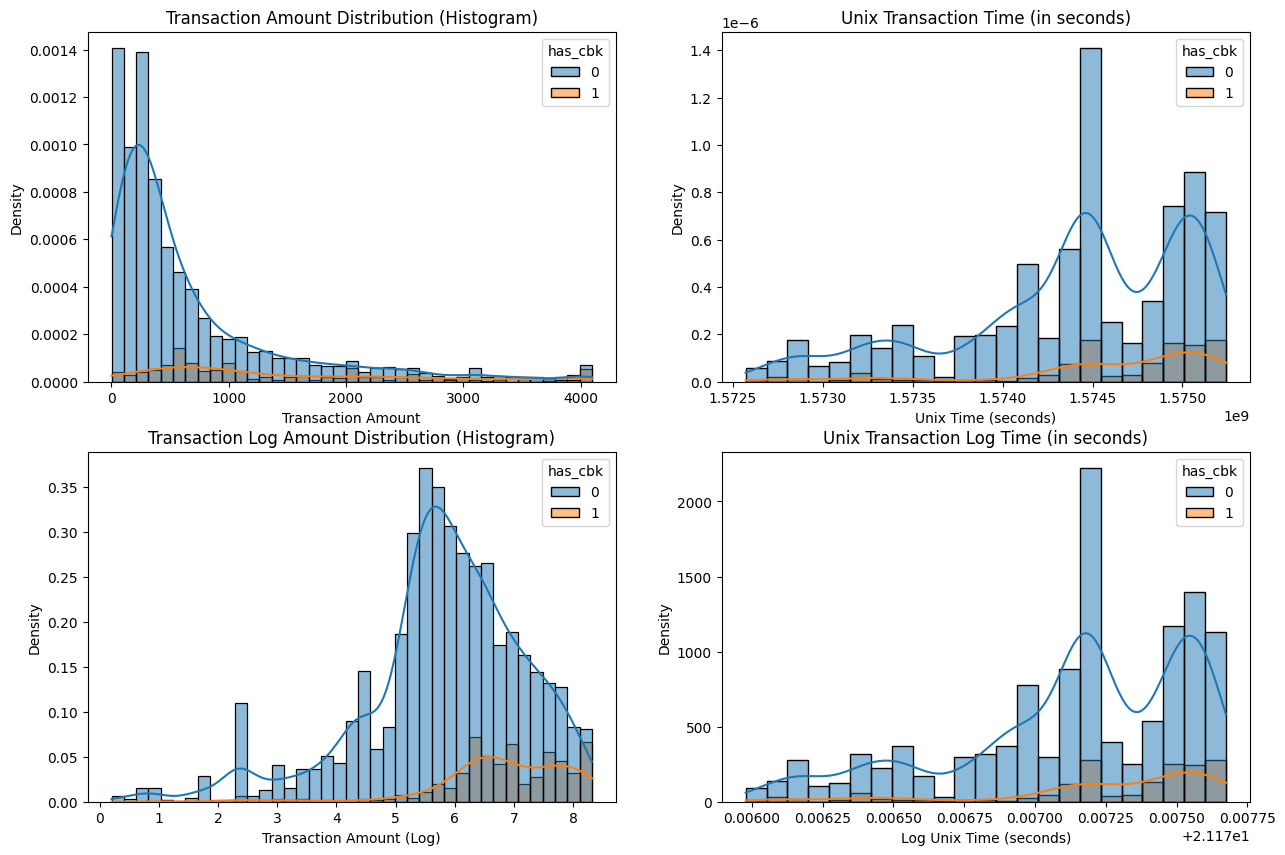

In [16]:
fig, ax = plt.subplots(figsize=(15,10), ncols=2, nrows=2) 

sns.histplot(data=df, x='transaction_amount', hue='has_cbk', kde=True, ax=ax[0, 0], stat='density')
ax[0, 0].set_title('Transaction Amount Distribution (Histogram)')
ax[0, 0].set_xlabel('Transaction Amount')

sns.histplot(data=df, x='ts', hue='has_cbk', kde=True, ax=ax[0,1], stat='density')
ax[0,1].set_title('Unix Transaction Time (in seconds)')
ax[0,1].set_xlabel('Unix Time (seconds)')

sns.histplot(data=df, x='log_amount', hue='has_cbk', kde=True, ax=ax[1, 0], stat='density')
ax[1, 0].set_title('Transaction Log Amount Distribution (Histogram)')
ax[1, 0].set_xlabel('Transaction Amount (Log)')

sns.histplot(data=df, x='log_ts', hue='has_cbk', kde=True, ax=ax[1, 1], stat='density')
ax[1, 1].set_title('Unix Transaction Log Time (in seconds)')
ax[1, 1].set_xlabel('Log Unix Time (seconds)')

plt.show()


# 4. Other Features

In [20]:
# Sort by user and time to ensure correct order
df = df.sort_values(['user_id', 'transaction_date', 'has_cbk'])

# Calculate time difference between consecutive transactions for each user
df['last_transaction_amount'] = df.groupby("user_id")['transaction_amount'].shift() 
df['last_transaction_amount_diff'] = df.groupby("user_id")['transaction_amount'].diff()
df['number_of_distinct_merchants'] = df.groupby("user_id")['merchant_id'].transform('nunique')
df['ts_diff'] = df.groupby('user_id')['ts'].diff()

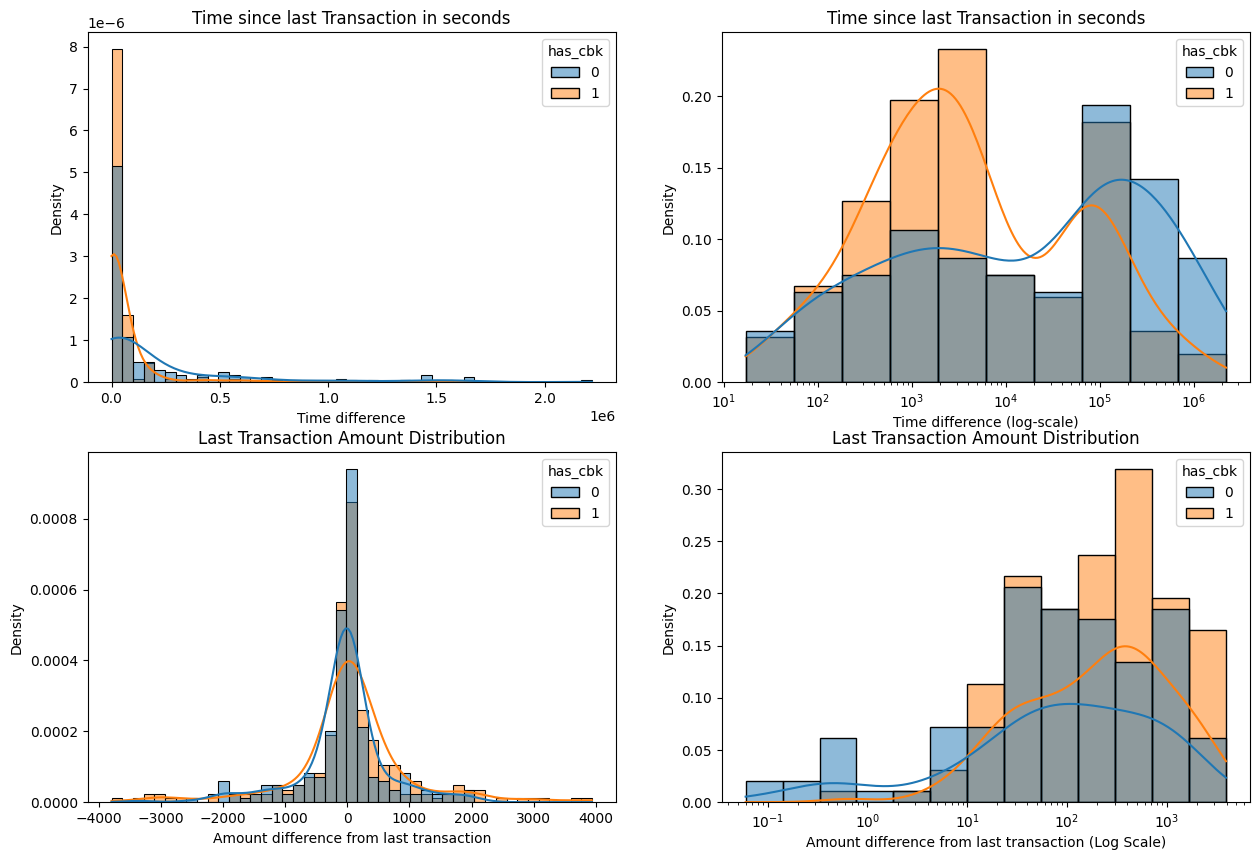

In [25]:
fig, ax = plt.subplots(figsize=(15,10), ncols=2, nrows=2) 

sns.histplot(data=df, x='ts_diff', hue='has_cbk', kde=True, ax=ax[0, 0], stat='density')
ax[0, 0].set_title('Time since last Transaction in seconds')
ax[0, 0].set_xlabel('Time difference')

sns.histplot(data=df, x='ts_diff', hue='has_cbk', kde=True, ax=ax[0,1], stat='density', log_scale=True)
ax[0,1].set_title('Time since last Transaction in seconds')
ax[0,1].set_xlabel('Time difference (log-scale)')

sns.histplot(data=df, x='last_transaction_amount_diff', hue='has_cbk', kde=True, ax=ax[1,0], stat='density')
ax[1,0].set_title('Last Transaction Amount Distribution')
ax[1,0].set_xlabel('Amount difference from last transaction')

sns.histplot(data=df, x='last_transaction_amount_diff', hue='has_cbk', kde=True, ax=ax[1,1], stat='density', log_scale=True)
ax[1,1].set_title('Last Transaction Amount Distribution')
ax[1,1].set_xlabel('Amount difference from last transaction (Log Scale)')

plt.show()


Clearly, we don't have features that seems to clearly discriminate between the levels of the target class.

## Understanding User Behavior

In [26]:
df['user_id'].nunique()
df['user_transactions'] = df.groupby("user_id")['transaction_id'].transform('count')

In [38]:
print("Users with a single transactions", round(df.query("user_transactions == 1").shape[0] / df.shape[0], 2))
print("Users with multiple transactionss", round(df.query("user_transactions > 1").shape[0] / df.shape[0], 2))

Users with a single transactions 0.77
Users with multiple transactionss 0.23


## Single Transactions Users

In [27]:
df_single_txs = df.query("user_transactions == 1") 

df_single_txs_has_cbk = df.query("user_transactions == 1 and has_cbk == 1")  
df_single_txs_no_cbk = df.query("user_transactions == 1 and has_cbk == 0") 

In [28]:
df_single_txs_has_cbk.describe()

,transaction_id,merchant_id,user_id,transaction_date,transaction_amount,device_id,has_cbk,ts,log_amount,log_ts,time_since_last_transaction,last_transaction_amount,last_transaction_amount_diff,number_of_distinct_merchants,ts_diff,user_transactions
count,6.400000e+01,64.000000,64.000000,64,64.000000,47.000000,64.0,6.400000e+01,64.000000,64.000000,0,0.0,0.0,64.0,0.0,64.0
mean,2.132192e+07,51307.140625,55283.578125,2019-11-23 08:49:01.325245696,1911.728594,505606.553191,1.0,1.574499e+09,7.034669,21.177203,NaT,NaN,NaN,1.0,NaN,1.0
min,2.132054e+07,1017.000000,900.000000,2019-11-03 17:02:15.187624,10.470000,6638.000000,1.0,1.572801e+09,2.348514,21.176124,NaT,NaN,NaN,1.0,NaN,1.0
25%,2.132119e+07,20652.750000,37017.250000,2019-11-20 19:05:13.225660928,569.635000,284707.500000,1.0,1.574277e+09,6.344975,21.177062,NaT,NaN,NaN,1.0,NaN,1.0
50%,2.132208e+07,53041.000000,59840.500000,2019-11-23 01:08:51.188467968,1832.670000,512700.000000,1.0,1.574471e+09,7.513497,21.177185,NaT,NaN,NaN,1.0,NaN,1.0
75%,2.132264e+07,82206.000000,79788.750000,2019-11-28 22:18:34.802758912,3076.632500,701284.500000,1.0,1.574980e+09,8.031020,21.177508,NaT,NaN,NaN,1.0,NaN,1.0
max,2.132353e+07,99644.000000,99876.000000,2019-12-01 01:50:22.799457,4055.580000,990288.000000,1.0,1.575165e+09,8.307849,21.177626,NaT,NaN,NaN,1.0,NaN,1.0
std,9.073516e+02,32344.975731,28924.745780,NaN,1398.191447,284763.950468,0.0,5.834975e+05,1.355676,0.000371,NaT,NaN,NaN,0.0,NaN,0.0


In [29]:
df_single_txs_no_cbk.describe()

,transaction_id,merchant_id,user_id,transaction_date,transaction_amount,device_id,has_cbk,ts,log_amount,log_ts,time_since_last_transaction,last_transaction_amount,last_transaction_amount_diff,number_of_distinct_merchants,ts_diff,user_transactions
count,2.405000e+03,2405.000000,2405.000000,2405,2405.000000,1736.000000,2405.0,2.405000e+03,2405.000000,2405.000000,0,0.0,0.0,2405.0,0.0,2405.0
mean,2.132205e+07,49345.268191,50963.628274,2019-11-22 04:18:11.792193536,652.608827,495398.555876,0.0,1.574396e+09,5.820110,21.177138,NaT,NaN,NaN,1.0,NaN,1.0
min,2.132040e+07,16.000000,6.000000,2019-11-01 01:27:15.811098,2.110000,4.000000,0.0,1.572572e+09,0.746688,21.175978,NaT,NaN,NaN,1.0,NaN,1.0
25%,2.132129e+07,23781.000000,25488.000000,2019-11-18 15:29:38.794281984,192.820000,246168.250000,0.0,1.574091e+09,5.261757,21.176944,NaT,NaN,NaN,1.0,NaN,1.0
50%,2.132208e+07,49205.000000,52243.000000,2019-11-23 01:03:21.938266880,354.730000,491621.000000,0.0,1.574471e+09,5.871357,21.177185,NaT,NaN,NaN,1.0,NaN,1.0
75%,2.132284e+07,74782.000000,75682.000000,2019-11-28 18:28:59.575816960,775.850000,749599.000000,0.0,1.574966e+09,6.653959,21.177499,NaT,NaN,NaN,1.0,NaN,1.0
max,2.132360e+07,99799.000000,99974.000000,2019-12-01 23:16:32.812632,4080.030000,999843.000000,0.0,1.575242e+09,8.313860,21.177675,NaT,NaN,NaN,1.0,NaN,1.0
std,9.112898e+02,29016.397527,29076.536334,NaN,761.455247,288135.576687,0.0,6.473997e+05,1.312993,0.000411,NaT,NaN,NaN,0.0,NaN,0.0


## Multiple Transactions Users

In [30]:
multiple_txs_and_cbk = df.query("user_transactions > 1 and has_cbk == 1")
multiple_txs_and_no_cbk = df.query("user_transactions > 1 and has_cbk == 0")

In [31]:
multiple_txs_and_cbk.describe()

,transaction_id,merchant_id,user_id,transaction_date,transaction_amount,device_id,has_cbk,ts,log_amount,log_ts,time_since_last_transaction,last_transaction_amount,last_transaction_amount_diff,number_of_distinct_merchants,ts_diff,user_transactions
count,3.270000e+02,327.000000,327.000000,327,327.000000,277.000000,327.0,3.270000e+02,327.000000,327.000000,260,260.000000,260.000000,327.000000,2.600000e+02,327.000000
mean,2.132162e+07,45920.798165,52829.486239,2019-11-25 00:15:37.977311488,1363.902110,453735.942238,1.0,1.574641e+09,6.830342,21.177293,0 days 16:00:44.107260919,1281.313500,60.780885,1.562691,5.764409e+04,8.620795
min,2.132040e+07,1308.000000,2708.000000,2019-11-01 19:19:50.609011,2.890000,486.000000,1.0,1.572636e+09,1.061257,21.176019,0 days 00:00:17.225608,1.300000,-3794.490000,1.000000,1.700000e+01,2.000000
25%,2.132088e+07,17771.000000,18078.000000,2019-11-22 19:27:13.607327488,565.580000,262327.000000,1.0,1.574451e+09,6.337851,21.177172,0 days 00:11:47.187994500,534.020000,-139.227500,1.000000,7.080000e+02,3.000000
50%,2.132146e+07,48126.000000,58905.000000,2019-11-27 22:11:06.819239936,963.890000,438940.000000,1.0,1.574893e+09,6.870977,21.177453,0 days 00:48:07.117018,859.275000,18.045000,1.000000,2.886500e+03,5.000000
75%,2.132219e+07,68805.000000,79526.000000,2019-11-29 20:59:20.408324864,2040.085000,670695.000000,1.0,1.575061e+09,7.620747,21.177560,0 days 14:39:55.033321750,2020.147500,306.775000,2.000000,5.279475e+04,13.000000
max,2.132358e+07,99510.000000,99396.000000,2019-12-01 22:45:37.873639,4097.210000,978084.000000,1.0,1.575240e+09,8.318062,21.177674,16 days 18:45:38.942664,4097.210000,3936.630000,4.000000,1.449939e+06,31.000000
std,8.834448e+02,28477.703808,32422.733352,NaN,1099.612791,262753.840456,0.0,6.228242e+05,1.043787,0.000396,1 days 22:54:03.172212994,1097.028276,968.399156,0.855270,1.688432e+05,8.464103


In [32]:
multiple_txs_and_no_cbk.describe()

,transaction_id,merchant_id,user_id,transaction_date,transaction_amount,device_id,has_cbk,ts,log_amount,log_ts,time_since_last_transaction,last_transaction_amount,last_transaction_amount_diff,number_of_distinct_merchants,ts_diff,user_transactions
count,4.030000e+02,403.000000,403.000000,403,403.000000,309.000000,403.0,4.030000e+02,403.000000,403.000000,235,235.000000,235.000000,403.000000,2.350000e+02,403.000000
mean,2.132199e+07,47254.870968,48187.689826,2019-11-22 11:57:10.346542336,789.981712,519895.585761,0.0,1.574424e+09,5.695425,21.177155,2 days 08:16:03.255291319,873.889234,-51.187532,1.138958,2.025633e+05,3.699752
min,2.132041e+07,91.000000,266.000000,2019-11-01 10:23:50.555604,1.220000,2.000000,0.0,1.572604e+09,0.198851,21.175999,0 days 00:00:23.509238,1.220000,-3367.100000,1.000000,2.400000e+01,2.000000
25%,2.132113e+07,25496.000000,23123.000000,2019-11-18 14:34:39.159119872,164.745000,305347.000000,0.0,1.574088e+09,5.104378,21.176942,0 days 00:22:35.082169500,211.335000,-167.165000,1.000000,1.355000e+03,2.000000
50%,2.132197e+07,42178.000000,49106.000000,2019-11-23 14:38:21.445003008,417.660000,534341.000000,0.0,1.574520e+09,6.034668,21.177216,0 days 07:47:08.411699,509.700000,0.060000,1.000000,2.802900e+04,2.000000
75%,2.132286e+07,72057.000000,74915.000000,2019-11-29 01:39:48.910817536,1010.455000,735990.000000,0.0,1.574992e+09,6.918156,21.177516,2 days 06:23:08.825034500,1091.135000,104.030000,1.000000,1.957890e+05,4.000000
max,2.132359e+07,99730.000000,99850.000000,2019-12-01 20:48:10.921857,4091.830000,991631.000000,0.0,1.575233e+09,8.316748,21.177669,25 days 16:23:02.273399,4091.830000,2020.360000,4.000000,2.218983e+06,31.000000
std,9.611086e+02,29466.111461,29618.729628,NaN,978.272630,274516.572743,0.0,6.804666e+05,1.813981,0.000432,4 days 08:47:01.256501064,1012.414352,709.153316,0.429678,3.772213e+05,4.295859
